In [69]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
from matplotlib import pyplot as plt
import h5py
# Load the image
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


In [70]:
def create_video_from_frames(frame_array, output_path, fps=30):
    """
    Create a video from an array of frames and save to the specified path.

    :param frame_array: A numpy array of shape (N, h, w, 3) containing the frames
    :param output_path: Path where the output video will be saved
    :param fps: Frames per second of the output video
    """
    # Extract the frame dimensions
    N, h, w, _ = frame_array.shape
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' for .mp4 files
    out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))
    
    for i in range(N):
        # The frames must be in BGR format for cv2
        # If the frames are in RGB format, convert them to BGR
        # print(cv2.COLOR_RGB2RGB)
        img = frame_array[i]
        # GOOD red: hsv_low = [0,100,0], hsv_high=[50,255,255]
        # GOOD green:  [40, 25,50], [80,100,100]
        
        # masked_img, idx = find_hsv_puck(frame_array[i], hsv_low = [0,100,0], hsv_high=[50,255,255]) #h=[0,30], s=[25,255], v=[119,255]) #cv2.cvtColor(find_green_puck(frame_array[i]), cv2.COLOR_RGB2BGR)
        # frame = np.concatenate((img, masked_img), axis=1)
        frame = img
        out.write(frame)  # Write the frame

    
    out.release()  # Release the VideoWriter

In [154]:
def find_hsv_puck(image, color=None, hsv_low=[0,0,0], hsv_high=[255, 255, 255], apply_mask=False):
    if color is not None:
        hsv_low, hsv_high = color[0], color[1]
    # hsv_alt should e a lit
    h, w, _ = image.shape
    
    # Convert the left half of the image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # We'll lower the saturation and value thresholds to possibly capture a darker green
    refined_lower = np.array(hsv_low)  # Lower saturation and value
    refined_upper = np.array(hsv_high)
    # print(hsv_image[:,:,2])
    # Create a mask for green color in the left half with the refined thresholds
    refined_mask = cv2.inRange(hsv_image, refined_lower, refined_upper)
    remove_table_edges_mask = np.zeros((h,w), dtype=np.uint8)
    # remove_table_edges_mask[0:175, 30:290] = 1
    # remove_table_edges_mask[, :] = 1
    # refined_mask *= remove_table_edges_mask
    if apply_mask:
        refined_mask[:,:290] = 0
        refined_mask[:,670:] = 0
        refined_mask[800:, :] = 0
        refined_mask[:50, :] = 0
        # refined_mask[
    puck_idx = np.where(refined_mask)
    refined_result = cv2.bitwise_and(image, image, mask=refined_mask)
    
    return cv2.cvtColor(refined_result,cv2.COLOR_HSV2RGB), puck_idx, np.stack([refined_mask,refined_mask,refined_mask]).transpose(1,2,0)

# Function to recursively save dictionary contents to HDF5 file
def save_dict_to_hdf5(dic, hdf5_file, path='/'):
    for key, item in dic.items():
        if isinstance(item, (np.ndarray, list)):  # Save datasets
            hdf5_file.create_dataset(path + key, data=item)
        elif isinstance(item, dict):  # Create a group and recurse
            group = hdf5_file.create_group(path + key)
            save_dict_to_hdf5(item, hdf5_file, path + key + '/')
        else:
            raise ValueError(f"Cannot save key '{key}' with type {type(item)}")

def load_hdf5_to_dict(datapath):
    """
    Load a hdf5 dataset into a dictionary.

    :param datapath: Path to the hdf5 file.
    :return: Dictionary with the dataset contents.
    """
    data_dict = {}
    # Open the hdf5 file
    with h5py.File(datapath, 'r') as hdf:
        # Loop through groups and datasets
        def recursively_save_dict_contents_to_group(h5file, current_dict):
            """
            Recursively traverse the hdf5 file to save all contents to a Python dictionary.
            """
            for key, item in h5file.items():
                if isinstance(item, h5py.Dataset):  # if it's a dataset
                    current_dict[key] = item[()]  # load the dataset into the dictionary
                elif isinstance(item, h5py.Group):  # if it's a group (which can contain other groups or datasets)
                    current_dict[key] = {}
                    recursively_save_dict_contents_to_group(item, current_dict[key])
        # Start the recursive function
        recursively_save_dict_contents_to_group(hdf, data_dict)

    return data_dict

def pixel2loc(xs,ys):
    xs = np.array(xs) - 500 
    ys = np.array(ys) - 2100
    xy_pixel = np.stack([-xs,ys])
    # xy_pixel -= np.array([[2100,500]])
    xy_robot_frame = xy_pixel * 0.001
    return xy_robot_frame
    # ys -= 273 
    # ys_range = np.nanmax(ys)
    # ys /= ys_range
    # ys -= 0.5
    # ys *= 0.8      
    # xs -= 922
    # xs /= ys_range
    # xs *= (1 * 0.8)
    # return np.stack([xs,ys])
    
def homography_transform(image, get_save=False):
    # image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    mousepos = (0,0,1)
    Mimg = np.load('../Mimg.npy')
    
    upscale_constant = 3
    image = cv2.resize(image, (640, 480))
    original_size = np.array([640, 480])
    visual_downscale_constant = 2
    save_downscale_constant = 1
    offset_constants = np.array((2100, 500))
    save_image = None
    if get_save:
        save_image = cv2.resize(image, (int(640/save_downscale_constant), int(480/save_downscale_constant)))
    image = cv2.resize(image, (int(640*upscale_constant), int(480*upscale_constant)), 
                interpolation = cv2.INTER_LINEAR)
    dst = cv2.warpPerspective(image,Mimg,original_size * upscale_constant)
    # dst = cv2.rotate(dst, cv2.ROTATE_90_CLOCKWISE)
    showdst = dst #cv2.resize(dst, (int(480*upscale_constant / visual_downscale_constant), int(640*upscale_constant / visual_downscale_constant)), 
                # interpolation = cv2.INTER_LINEAR)
    return showdst, save_image

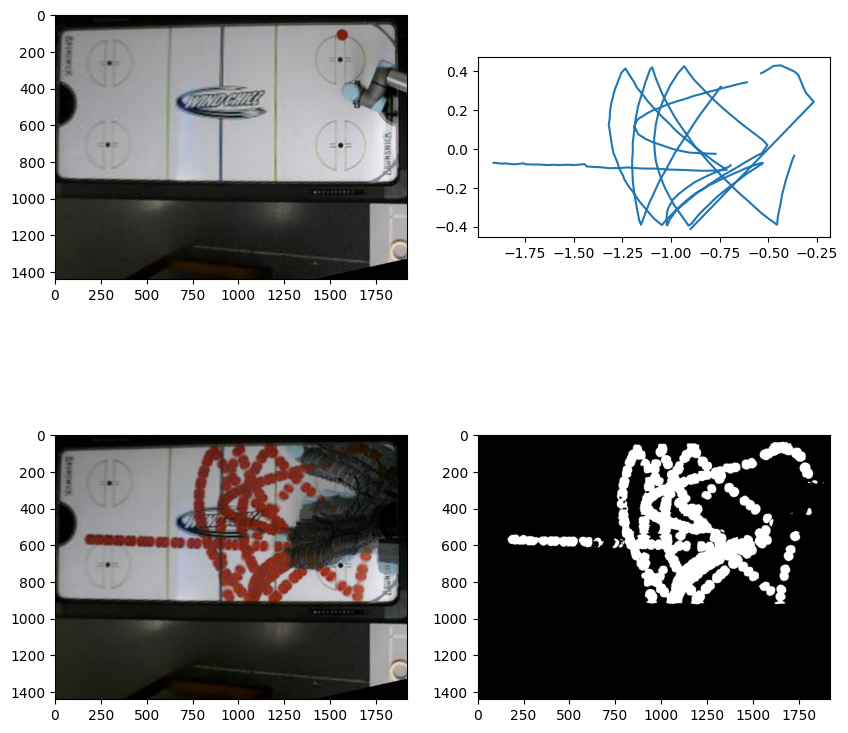

In [156]:
# try:
plt.rcParams['figure.figsize'] = [10, 10]
for traj in [257]:
    for _ in [0]:
        path = f'/datastor1/calebc/public/data/mouse/trajectories/trajectory_data{traj}.hdf5'
        dataset_dict = {}
        dataset_dict = load_hdf5_to_dict(path)
        xs,ys = [], []
        create_video_from_frames(dataset_dict['train_img'], f'traj_videos/traj_video{traj}.mp4')
        imgs = dataset_dict['train_img']#[150:160]
        for i, img in enumerate(imgs):
            train_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            dst, save_img = homography_transform(train_img)

            green = [[40,100,50], [80,255,255]]
            red = [[0,100,50], [50,255,255]]
            
            refined_img, idx,mask = find_hsv_puck(dst, color=red, apply_mask=False)
            x,y = np.median(idx[0]), np.median(idx[1])
            xs.append(x)
            ys.append(y)
            if i == 0:
                img_puck_traj = dst 
                total_mask = mask
            else:
                total_mask = (total_mask | mask)
                img_puck_traj[:,:,0] = np.minimum(img_puck_traj[:,:,0], dst[:,:,0])
                img_puck_traj[:,:,1] = np.minimum(img_puck_traj[:,:,1], dst[:,:,1])
                img_puck_traj[:,:,2] = np.minimum(img_puck_traj[:,:,2], dst[:,:,2])
        
        xy_robot_frame = pixel2loc(xs, ys) #
        
        plt.figure()
        plt.subplot(2,2,1)
        plt.imshow(dst)
        plt.subplot(2,2,2)
        plt.plot(xy_robot_frame[1], xy_robot_frame[0])

        ax = plt.gca()  # Get current axes
        # ax.set_xlim(-0.3282, 0.378)
        # ax.set_ylim(-1.9,-0.3)
        ax.set_aspect(aspect='equal', adjustable='box')
        # ax.invert_yaxis()
        
        plt.subplot(2,2,3)
        plt.imshow(img_puck_traj)
        plt.subplot(2,2,4)
        plt.imshow(total_mask)
        plt.savefig(f'traj_videos/traj_plot{traj}.png')
        
        # Create a new HDF5 file
        # save_path = f'/datastor1/calebc/public/data/mouse/trajectories/trajectory_with_states/state_trajectory_data{traj}.hdf5'
        # dataset_dict['puck_state'] = xy_robot_frame
        # dataset_dict['puck_state_nan_mask'] = np.isnan(xy_robot_frame)
        # plt.close()
        # with h5py.File(save_path, 'w') as hdf5_file:
        #     save_dict_to_hdf5(dataset_dict, hdf5_file)
        # print(f'finished traj {traj}')
